In [2]:
import SimPEG as simpeg
import simpegMT as simpegmt
import numpy as np, os
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
## Setup the modelling
# Setting up 1D mesh and conductivity models to forward model data.

# Frequency
nFreq = 31
freqs = np.logspace(3,-3,nFreq)
# Set mesh parameters
ct = 20
air = simpeg.Utils.meshTensor([(ct,16,1.4)])
core = np.concatenate( (  np.kron(simpeg.Utils.meshTensor([(ct,10,-1.3)]),np.ones((5,))) , simpeg.Utils.meshTensor([(ct,5)]) ) )
bot = simpeg.Utils.meshTensor([(core[0],10,-1.4)])
x0 = -np.array([np.sum(np.concatenate((core,bot)))])
# Make the model
m1d = simpeg.Mesh.TensorMesh([np.concatenate((bot,core,air))], x0=x0)

In [4]:
## Make a model
# Some model varibles
active = m1d.vectorCCx<0.
layer1 = (m1d.vectorCCx<-500.) & (m1d.vectorCCx>=-800.)
layer2 = (m1d.vectorCCx<-3500.) & (m1d.vectorCCx>=-5000.)
# Set the conductivity values
sig_half = 2e-3
sig_air = 1e-8
sig_layer1 = .2
sig_layer2 = .2
# Make the true conductivity
sigma_true = np.ones(m1d.nCx)*sig_air
sigma_true[active] = sig_half
sigma_true[layer1] = sig_layer1
sigma_true[layer2] = sig_layer2
# Extract the model 
m_true = np.log(sigma_true[active])
# Make a background model
sigma_0 = np.ones(m1d.nCx)*sig_air
sigma_0[active] = sig_half
# Define the background model
m_0 = np.log(sigma_0[active])

In [5]:
## Setup the layout of the survey, set the sources and the connected receivers
# Receivers 
rxList = []
for rxType in ['z1dr','z1di']:
    rxList.append(simpegmt.SurveyMT.RxMT(simpeg.mkvc(np.array([0.0]),2).T,rxType))
# Source list
srcList =[]
for freq in freqs:
        srcList.append(simpegmt.SurveyMT.srcMT_polxy_1Dprimary(rxList,freq))
# Make the survey
survey = simpegmt.SurveyMT.SurveyMT(srcList)
survey.mtrue = m_true
# Set the mapping
actMap = simpeg.Maps.ActiveCells(m1d, active, np.log(1e-8), nC=m1d.nCx)
mappingExpAct = simpeg.Maps.ExpMap(m1d) * actMap
# Set the problem
problem = simpegmt.ProblemMT1D.eForm_psField(m1d,sigmaPrimary=sigma_0,mapping=mappingExpAct)
from pymatsolver import MumpsSolver
problem.solver = MumpsSolver
problem.pair(survey)

In [6]:
## Forward model observed data 
# Project the data
std = 0.05 # 5% std
if os.path.isfile('MT1D_dtrue.npy') and os.path.isfile('MT1D_dobs.npy'):
    d_true = np.load('MT1D_dtrue.npy')
    d_obs = np.load('MT1D_dobs.npy')
else:
    d_true = survey.dpred(m_true)
    np.save('MT1D_dtrue.npy',d_true)
    d_obs = d_true + std*abs(d_true)*np.random.randn(*d_true.shape)
    np.save('MT1D_dobs.npy',d_obs)
# Assign the dobs
survey.dtrue = d_true
survey.dobs = d_obs
survey.std = np.abs(survey.dobs*std) + 0.01*np.linalg.norm(survey.dobs) 
# Assign the data weight
survey.Wd = 1/survey.std 

In [7]:
## Setup the inversion proceedure

# Define a counter
C =  simpeg.Utils.Counter()
# Set the optimization
opt = simpeg.Optimization.InexactGaussNewton(maxIter = 30)
opt.counter = C
opt.LSshorten = 0.5
opt.remember('xc')
# Data misfit
dmis = simpeg.DataMisfit.l2_DataMisfit(survey)
# Regularization
regMesh = simpeg.Mesh.TensorMesh([m1d.hx[problem.mapping.sigmaMap.maps[-1].indActive]],m1d.x0)
reg = simpeg.Regularization.Tikhonov(regMesh)
reg.smoothModel = False
reg.alpha_s = 1e-7
reg.alpha_x = 1.
# reg.alpha_xx = .001
# Inversion problem
invProb = simpeg.InvProblem.BaseInvProblem(dmis, reg, opt)
invProb.counter = C
# Beta cooling
beta = simpeg.Directives.BetaSchedule()
betaest = simpeg.Directives.BetaEstimate_ByEig(beta0_ratio=0.75)
targmis = simpeg.Directives.TargetMisfit()
targmis.target = .75 * survey.nD
saveModel = simpeg.Directives.SaveModelEveryIteration()
saveModel.fileName = 'Inversion_TargMisEqnDregMesh_smoothFalse'
# Create an inversion object
inv = simpeg.Inversion.BaseInversion(invProb, directiveList=[beta,betaest,targmis,saveModel]) 


In [7]:
%%time
simpegmt.Utils.dataUtils.printTime()
mopt = inv.run(m_0)

Fri, 10 Jul 2015 17:10:39 +0000
SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using same solver as the problem***
SimPEG.l2_DataMisfit is creating default weightings for Wd.
SimPEG.SaveModelEveryIteration will save your models as: '###-Inversion_TargMisEqnDregMesh_smoothFalse.npy'
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
   0  2.02e+05  2.18e+05  0.00e+00  2.18e+05    4.01e+04      0              
   1  2.02e+05  2.50e+04  2.21e-03  2.54e+04    5.65e+03      0              
   2  2.02e+05  3.36e+03  4.81e-03  4.33e+03    9.87e+02      0   Skip BFGS  
   3  2.52e+04  1.70e+03  5.46e-03  1.83e+03    2.73e+02      0   Skip BFGS  
   4  2.52e+04  8.89e+02  2.10e-02  1.42e+03    2.47e+02      0  

/home/gudni/anaconda/lib/python2.7/site-packages/numpy/ma/core.py:2834: FutureWarning: Numpy has detected that you (may be) writing to an array returned
by numpy.diagonal or by selecting multiple fields in a record
array. This code will likely break in a future numpy release --
see numpy.diagonal or arrays.indexing reference docs for details.
The quick fix is to make an explicit copy (e.g., do
arr.diagonal().copy() or arr[['f0','f1']].copy()).
  if (obj.__array_interface__["data"][0]
/home/gudni/anaconda/lib/python2.7/site-packages/numpy/ma/core.py:2835: FutureWarning: Numpy has detected that you (may be) writing to an array returned
by numpy.diagonal or by selecting multiple fields in a record
array. This code will likely break in a future numpy release --
see numpy.diagonal or arrays.indexing reference docs for details.
The quick fix is to make an explicit copy (e.g., do
arr.diagonal().copy() or arr[['f0','f1']].copy()).
  != self.__array_interface__["data"][0]):


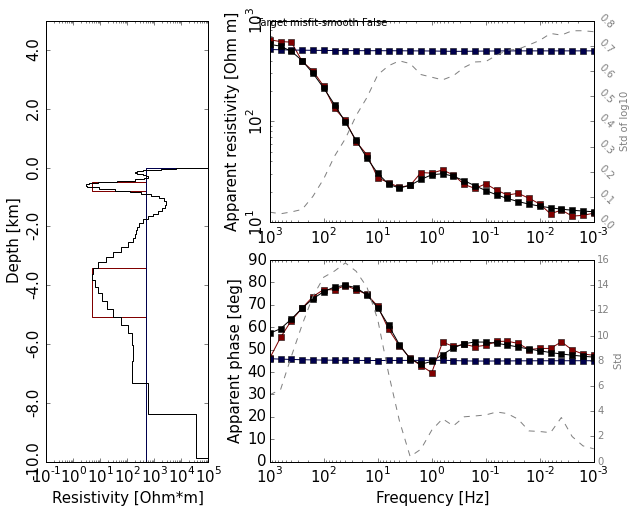

In [8]:
%matplotlib inline
simpegmt.Utils.dataUtils.plotMT1DModelData(problem,[m_0,mopt])
plt.suptitle('Target misfit-smooth False')
plt.show()


In [9]:
reg.alpha_xx = 0.001
saveModel.fileName = 'Inversion_TargMisEqnDregMesh_smoothFalseWxx'

In [10]:
%%time
simpegmt.Utils.dataUtils.printTime()
moptWxx = inv.run(m_0)

Fri, 10 Jul 2015 17:12:05 +0000
SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using same solver as the problem***
SimPEG.SaveModelEveryIteration will save your models as: '###-Inversion_TargMisEqnDregMesh_smoothFalseWxx.npy'
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
   0  2.49e+05  2.18e+05  0.00e+00  2.18e+05    4.01e+04      0   Skip BFGS  
   1  2.49e+05  2.50e+04  2.21e-03  2.55e+04    5.64e+03      0   Skip BFGS  
   2  2.49e+05  3.37e+03  4.75e-03  4.55e+03    9.91e+02      0   Skip BFGS  
   3  3.11e+04  1.77e+03  4.96e-03  1.92e+03    2.82e+02      0   Skip BFGS  
   4  3.11e+04  9.80e+02  1.71e-02  1.51e+03    2.18e+02      0   Skip BFGS  
   5  3.11e+04  7.36e+02  1.87e-02  1.32e+03    1.07e+02      0              
   6  3.89e+03  6.09

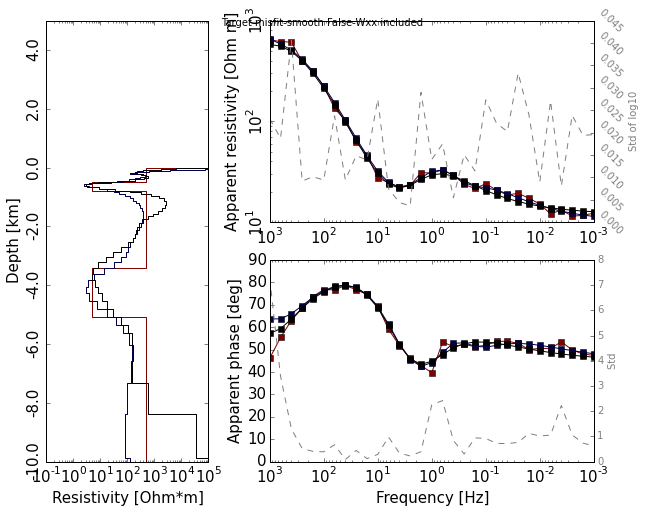

In [11]:
%matplotlib inline
simpegmt.Utils.dataUtils.plotMT1DModelData(problem,[moptWxx,mopt])

plt.suptitle('Target misfit-smooth False-Wxx included')
plt.show()

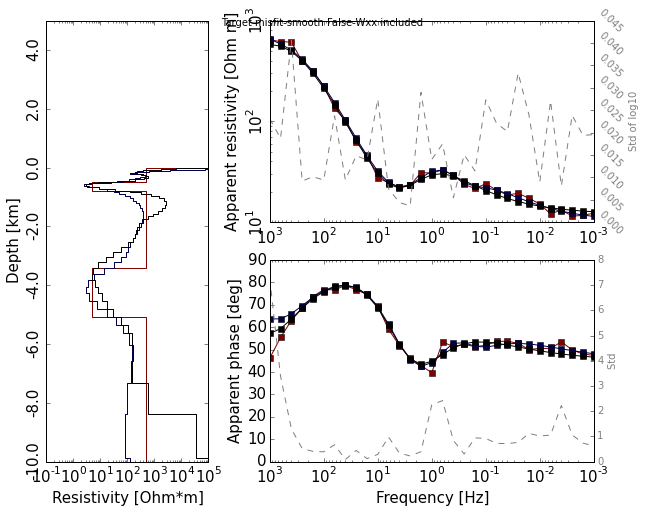